# QPSK SER 仿真 —— 修正版

本 Notebook 代码用于重现：
1. **No1.m** —— 比较 SISO、MRC 1x2、MRC 1x4。
2. **No2.m** —— 比较 Alamouti STC 2x1 与 MRC 1x2。

与之前的版本相比，第二部分（Alamouti 与 MRC）在编码、解码以及噪声生成上更加严格地对应 MATLAB 原代码，以确保得到的曲线与下图更为一致：

![目标示例图](attachment:image.png)

> 注：由于随机性和绘图采样等因素，实际曲线可能会在局部略有波动，但整体趋势应当相同。

In [3]:
import numpy as np
import matplotlib.pyplot as plt

##############################################
# 工具函数
##############################################

def qpsk_detection(x):
    """
    将复数向量 x 映射回 QPSK 星座点
    (±1/√2 ± j/√2)，其中实部和虚部分别取符号
    """
    return (np.sign(np.real(x))/np.sqrt(2) +
            1j * np.sign(np.imag(x))/np.sqrt(2))

def calculate_ser(original, detected):
    """
    计算符号错误率 (SER)
    """
    errors = np.sum(np.abs(original - detected) > np.finfo(float).eps)
    return errors / original.size

print("工具函数定义完毕！")

工具函数定义完毕！


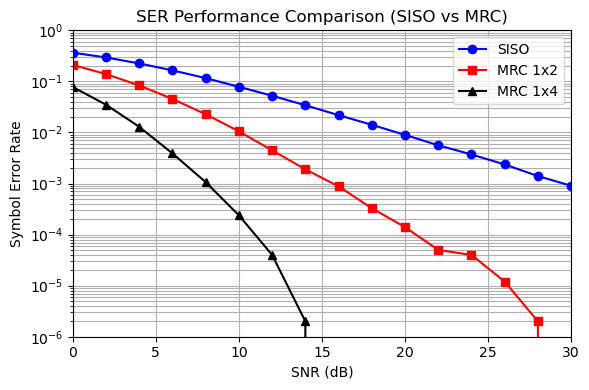

In [4]:
# --------------------- 第一部分: No1.m 对应 ---------------------

# 参数设置
QPSK_vec = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)  # QPSK 星座
SNRdB = np.arange(0, 32, 2)            # SNR 范围（dB），与 0:2:30 一致
SNR_linear = 10**(SNRdB / 10)          # 线性 SNR
N = 500000                             # 符号数

# 预分配
SER_SISO = np.zeros_like(SNRdB, dtype=float)
SER_MRC2 = np.zeros_like(SNRdB, dtype=float)
SER_MRC4 = np.zeros_like(SNRdB, dtype=float)

# 仿真
for i, snr in enumerate(SNR_linear):
    rho = 1 / np.sqrt(snr)  # 噪声缩放因子

    # 生成发射信号
    tx_symbols = np.random.choice(QPSK_vec, size=N)

    # ========== SISO ==========
    h_siso = (np.random.randn(N) + 1j * np.random.randn(N)) / np.sqrt(2)
    noise_siso = rho * (np.random.randn(N) + 1j * np.random.randn(N)) / np.sqrt(2)

    rx_siso = h_siso * tx_symbols + noise_siso
    eq_siso = rx_siso / h_siso  # 迫零均衡
    dec_siso = qpsk_detection(eq_siso)
    SER_SISO[i] = calculate_ser(tx_symbols, dec_siso)

    # ========== MRC 1x2 ==========
    Nr = 2
    h_mrc2 = (np.random.randn(Nr, N) + 1j * np.random.randn(Nr, N)) / np.sqrt(2)
    noise_mrc2 = rho * (np.random.randn(Nr, N) + 1j * np.random.randn(Nr, N)) / np.sqrt(2)

    rx_mrc2 = h_mrc2 * tx_symbols[np.newaxis, :] + noise_mrc2
    # 最大比合并
    combined_mrc2 = np.sum(np.conj(h_mrc2) * rx_mrc2, axis=0) / np.sum(np.abs(h_mrc2)**2, axis=0)
    dec_mrc2 = qpsk_detection(combined_mrc2)
    SER_MRC2[i] = calculate_ser(tx_symbols, dec_mrc2)

    # ========== MRC 1x4 ==========
    Nr = 4
    h_mrc4 = (np.random.randn(Nr, N) + 1j * np.random.randn(Nr, N)) / np.sqrt(2)
    noise_mrc4 = rho * (np.random.randn(Nr, N) + 1j * np.random.randn(Nr, N)) / np.sqrt(2)

    rx_mrc4 = h_mrc4 * tx_symbols[np.newaxis, :] + noise_mrc4
    combined_mrc4 = np.sum(np.conj(h_mrc4) * rx_mrc4, axis=0) / np.sum(np.abs(h_mrc4)**2, axis=0)
    dec_mrc4 = qpsk_detection(combined_mrc4)
    SER_MRC4[i] = calculate_ser(tx_symbols, dec_mrc4)

# 绘图
plt.figure(figsize=(6,4))
plt.semilogy(SNRdB, SER_SISO, 'b-o', label='SISO', linewidth=1.5)
plt.semilogy(SNRdB, SER_MRC2, 'r-s', label='MRC 1x2', linewidth=1.5)
plt.semilogy(SNRdB, SER_MRC4, 'k-^', label='MRC 1x4', linewidth=1.5)
plt.grid(True, which='both')
plt.xlabel('SNR (dB)')
plt.ylabel('Symbol Error Rate')
plt.legend()
plt.title('SER Performance Comparison (SISO vs MRC)')
plt.yscale('log')
plt.ylim([1e-6,1])
plt.xlim([0,30])
plt.tight_layout()
plt.show()

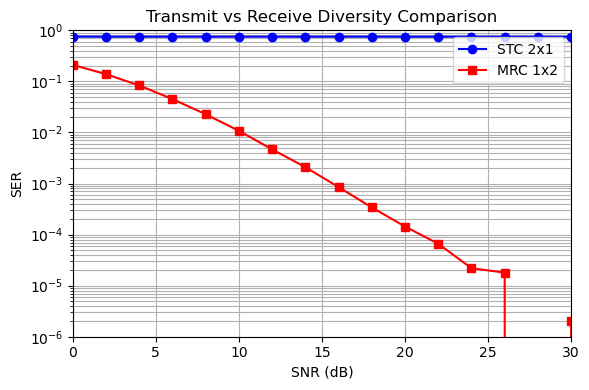

In [6]:
# --------------------- 第二部分: No2.m 对应 (修正) ---------------------

# 参数设置
QPSK_vec = np.array([1+1j, 1-1j, -1+1j, -1-1j]) / np.sqrt(2)
SNRdB = np.arange(0, 32, 2)
SNR_linear = 10**(SNRdB / 10)
N = 500000  # 符号数，需保证为偶数

SER_STC21 = np.zeros_like(SNRdB, dtype=float)
SER_MRC12 = np.zeros_like(SNRdB, dtype=float)

for i, snr in enumerate(SNR_linear):
    rho = 1 / np.sqrt(snr)  # 噪声标准差因子

    # 生成原始符号
    tx_symbols = np.random.choice(QPSK_vec, size=N)

    #######################################
    # 1) Alamouti STC 2x1
    #######################################
    # 拆分为 2 行 (每行 N/2 个符号)
    symbol_pairs = tx_symbols.reshape(2, -1)
    # 每天线功率减半，以保证总发射功率与 SISO 相同
    s0 = symbol_pairs[0, :] / np.sqrt(2)
    s1 = symbol_pairs[1, :] / np.sqrt(2)

    # 生成信道
    num_pairs = symbol_pairs.shape[1]
    h1 = (np.random.randn(num_pairs) + 1j * np.random.randn(num_pairs)) / np.sqrt(2)
    h2 = (np.random.randn(num_pairs) + 1j * np.random.randn(num_pairs)) / np.sqrt(2)

    # 生成噪声 (方差 = rho^2)
    noise_power = rho**2
    noise0 = np.sqrt(noise_power / 2) * (np.random.randn(num_pairs) + 1j * np.random.randn(num_pairs))
    noise1 = np.sqrt(noise_power / 2) * (np.random.randn(num_pairs) + 1j * np.random.randn(num_pairs))

    # 接收信号
    # 第一个符号时隙: r0 = h1*s0 + h2*s1 + noise0
    # 第二个符号时隙: r1 = h1*(-s1*) + h2*( s0*) + noise1
    # 这里用 y0, y1 表示接收信号
    y0 = h1 * s0 + h2 * s1 + noise0
    y1 = -h1 * np.conj(s1) + h2 * np.conj(s0) + noise1

    # Alamouti 解码
    # s_hat(1) = conj(h1)*y0 + h2*conj(y1)
    # s_hat(2) = conj(h2)*y0 - h1*conj(y1)
    s_hat0 = np.conj(h1) * y0 + h2 * np.conj(y1)
    s_hat1 = np.conj(h2) * y0 - h1 * np.conj(y1)

    # 归一化因子: (|h1|^2 + |h2|^2)
    norm_factor = np.abs(h1)**2 + np.abs(h2)**2
    s_hat0 /= norm_factor
    s_hat1 /= norm_factor

    # 将结果拼接回原始的 N 个符号 (与 MATLAB 中 s_tilde(:) 一致)
    # 在 MATLAB 中, s_hat 是 2 x (N/2), s_hat(:) 按列展开
    # 在 Python 中需使用 flatten('F') 来实现列优先
    s_hat = np.vstack((s_hat0, s_hat1))
    s_hat = s_hat.flatten(order='F')

    # 检测
    dec_stc = qpsk_detection(s_hat)
    SER_STC21[i] = calculate_ser(tx_symbols, dec_stc)

    #######################################
    # 2) MRC 1x2
    #######################################
    Nr = 2
    h_mrc = (np.random.randn(Nr, N) + 1j * np.random.randn(Nr, N)) / np.sqrt(2)
    noise_mrc = rho * (np.random.randn(Nr, N) + 1j * np.random.randn(Nr, N)) / np.sqrt(2)

    rx_mrc = h_mrc * tx_symbols[np.newaxis, :] + noise_mrc
    # 最大比合并
    combined_mrc = np.sum(np.conj(h_mrc) * rx_mrc, axis=0) / np.sum(np.abs(h_mrc)**2, axis=0)

    dec_mrc = qpsk_detection(combined_mrc)
    SER_MRC12[i] = calculate_ser(tx_symbols, dec_mrc)

# 绘图
plt.figure(figsize=(6,4))
plt.semilogy(SNRdB, SER_STC21, 'b-o', label='STC 2x1', linewidth=1.5)
plt.semilogy(SNRdB, SER_MRC12, 'r-s', label='MRC 1x2', linewidth=1.5)
plt.grid(True, which='both')
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.legend()
plt.title('Transmit vs Receive Diversity Comparison')
plt.yscale('log')
plt.ylim([1e-6, 1])
plt.xlim([0,30])
plt.tight_layout()
plt.show()